In [36]:
import numpy as np 
import matplotlib.pyplot as plt
np.random.seed(0)

## 1 Data Creation and Analysis

In this section, we are going to create and analyze data for mail spam detection.

Mathematically, the data is given by the set:

$$
X = \{ (x_1, y_1), (x_2, y_2), \dots, (x_i, y_i) \}
$$

where $x_i \in \mathbb{R}^D$ and $D$ is the dimensionality of the feature vector. In the mail spam detection task, we will set $D = 2$.

We will generate two datasets: one that is perfectly linearly separable and one that is not.



### 1.1 Create a Linearly Separable Dataset

We are going to create the first dataset using the `numpy` library. 
Remember that the dataset needs to be represented as a tuple of two numpy arrays:
- `X`: A numpy array of shape `(num_samples, 2)` representing the feature vectors.
- `y`: A numpy array of shape `(num_samples,)` representing the target labels.

We will create the dataset by generating normally distributed data with the help of `np.random.randn`, which returns samples from a normal distribution. To ensure the data is linearly separable, we will shift these distributions with an offset so they do not overlap. We can also control the spread of the data by adjusting the standard deviations (sigma values). 

For this email spam detection problem:
- The **negative class** (non-spam) will have greater dispersion, representing the variable nature of regular emails.
- The **spam class** will have smaller variation and be more tightly clustered.

#### Task:
In the function `create_data`, after generating the four numpy arrays:
1. **Concatenate the arrays**: 
    - Concatenate `X_neg` and `X_pos` to form the final `X` numpy array of shape `(X_neg.shape[0] + X_pos.shape[0], 2)`.
    - Concatenate `y_neg` and `y_pos` to form the final `y` numpy array of shape `(y_neg.shape[0] + y_pos.shape[0], )`.
    - *Hint*: You can use `np.vstack()` to vertically stack the feature arrays and `np.hstack()` to stack the labels.

2. **Randomly permute the data**: 
    - Randomly shuffle the data to avoid having 200 positive examples followed by 200 negative examples, as some algorithms (like the Perceptron) are sensitive to this issue.
    - *Hint*: You can use `np.random.permutation` to shuffle the data indices and reorder both `X` and `y` accordingly.

3. **Bias trick**:
    - we are going to implement the algorithm using the bias trick in order for the dimensions to be comatible we need to add one extra dimension to $x_i$
    - *Hint* 
3. **Return the final `X` and `y` arrays**: 
    - Make sure to return the shuffled `X` and `y` arrays as the final output of the function.


In [37]:
def create_data(num_samples_positive=200, num_samples_negative=200, offset_pos=np.full(2, 2), offset_neg=np.full(1, 1), sigma_pos=0.5, sigma_neg=0.75):

    X_neg = sigma_pos * np.random.randn(num_samples_negative, 2) - offset_neg
    y_neg = -np.ones((num_samples_negative, 1))

    X_pos = sigma_neg * np.random.randn(num_samples_positive, 2) + offset_pos 
    y_pos = np.ones((num_samples_positive, 1))

    X, y = None, None

    ###### Your code here ######
    X = np.vstack((X_neg, X_pos))
    y = np.vstack((y_neg, y_pos))

    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    y = y.flatten()

    ###########################

    return X, y

In [38]:
num_samples_positive = 200
num_samples_negative = 200

# create the linearly separable dataset
X, y = create_data(num_samples_positive, num_samples_negative)

#create the non-linearly separable dataset
X_n, y_n = create_data(num_samples_positive, num_samples_negative, sigma_pos=1.2, sigma_neg=1)

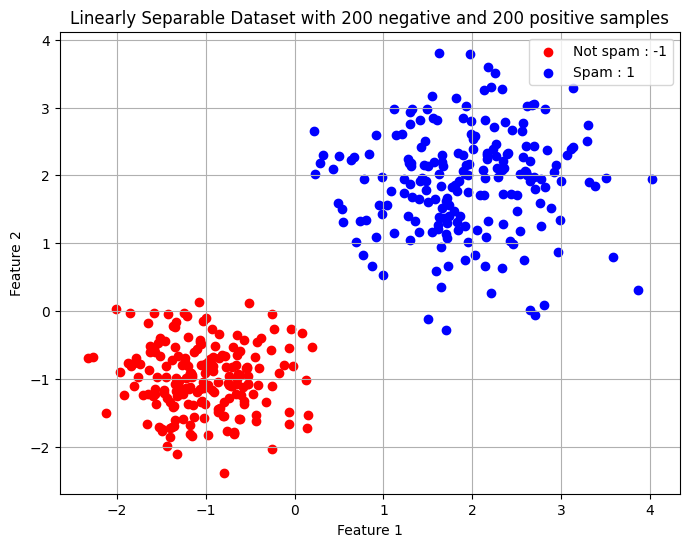

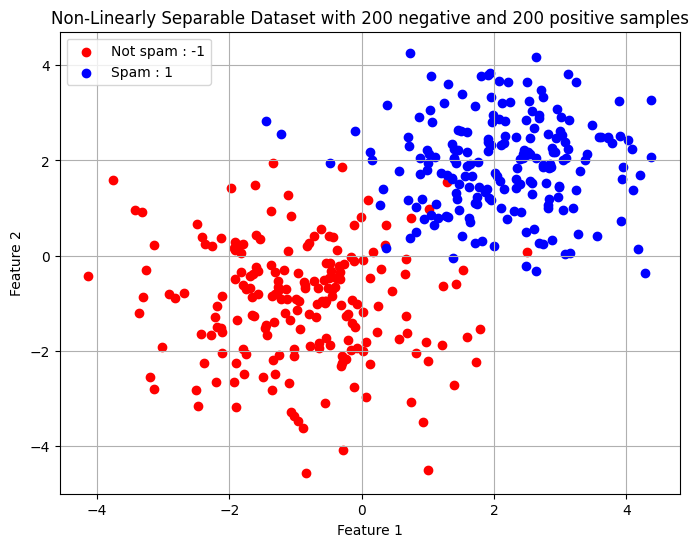

In [39]:
def plot_data(X, y, title='Linearly Separable Dataset'):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Not spam : -1')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Spam : 1')
    plt.title(f'{title} with {num_samples_negative} negative and {num_samples_positive} positive samples')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_data(X, y)
plot_data(X_n, y_n, title='Non-Linearly Separable Dataset')

## 2 PLA Implementation

In this section, we are going to implement two main components of the Perceptron Learning Algorithm (PLA):
1. **Prediction Function**: This function will return the predicted class of a given example based on the current weight vector and the PLA hypothesis function.
2. **Weight Update Function**: This function will return the updated weight vector based on the current training example and its corresponding label.

### 2.1 Prediction Function

The `predict` function should return the predicted class of the given input example based on the current weight vector and the PLA hypothesis. The hypothesis predicts the sign of the weighted sum of the features.

#### Inputs:
- `x`: The input example (a feature vector).
- `w`: The current weight vector.

#### Variables:
- `pred`: The predicted class label.

#### Return:
- `pred`: The predicted class (-1 or 1).

### 2.2 Weight Update Function

The `update_weights` function should return the updated weight vector after adjusting the current weight based on the misclassified training example and its true label.

#### Inputs:
- `x_t`: The input feature vector at timestep `t`.
- `y_t`: The true label corresponding to `x_t`.
- `w_t`: The weight vector at timestep `t`.

#### Variables:
- `w_t_1`: The updated weight vector after applying the update rule.

#### Return:
- `w_t_1`: The updated weight vector.


In [40]:
def predict(x, w):

    pred = None

    ######### Your code here #########
    activation = x @ w
    pred = np.where(activation >= 0, 1, -1)
    #################################

    return pred

def update_weights(x_t, y_t, w_t):

    w_t_1 = None

    ######### Your code here #########
    if y_t * predict(x_t, w_t) <= 0:
        w_t_1 = w_t + y_t * x_t
    else:
        w_t_1 = w_t

    #################################

    return w_t_1

## 3 Algorithm Training and Testing

In this section, we will focus on training and testing the perceptron algorithm. We will measure the algorithm's performance by checking how well it classifies emails as spam or not, based on the test set.

According to Tom Mitchell's definition, we need to evaluate the performance \( P \) of the algorithm. In this case, we can see the perfermence as the number of misclassified examples.

### 3.1 Compute Number of Misclassified Points

We need to implement a function `compute_misclassified_points` that calculates the number of misclassified points in a given set. You should use vectorization to compute this efficiently without using loops.

#### Input:
- `X`: A set of points to classify (shape: `(no_points, 3)`).
- `y`: The corresponding target labels (shape: `(no_points,)`).
- `w`: The weight vector of the algorithm.

#### Variables:
- `misclassified_points`: The number of points that are misclassified.

#### Return:
- `misclassified_points`: The total number of misclassified points.

### 3.2 Train the Perceptron

The function `train_perceptron` is responsible for training the algorithm by optimizing the weight parameters \( w \). The algorithm will continue updating the weights while misclassified points exist, or until it reaches a specified iteration limit. For each update, the tuple `(w_t, w_t_1, x_t, y_t)` should be appended to the `save_for_visualization` list.

#### Input:
- `X_train`: The training input set (shape: `(no_points, 3)`).
- `Y_train`: The corresponding training labels (shape: `(no_points,)`).
- `total_iterations`: The number of iterations after which the algorithm should stop, if it doesn't converge.

#### Variables:
- `current_iteration`: Keeps track of the current iteration count.
- `save_for_visualization`: A list of tuples containing `(w_t, w_t_1, x_t, y_t)` for each update to visualize decision boundaries.
- `w_t`: The weight vector at time \( t \).
- `w_t_1`: The weight vector at time \( t + 1 \).

### 3.3 Test the Perceptron

To evaluate the performance of the perceptron, we will compute the number of misclassified examples in the test set. The function `test_perceptron` should return the number of misclassified points from the test set.

#### Input:
- `X_test`: The set of test points.
- `y_test`: The corresponding test labels.
- `w`: The weights of the model.

#### Variables:
- `metric`: The number of misclassified points.


In [41]:
def compute_missclassified_points(X, y, w):
    
    missclassified_points = None

    ######### Your code here #########
    y_pred = predict(X, w)
    missclassified_points = np.sum(y_pred != y)

    #################################

    return missclassified_points


def train(X_train, y_train, total_iterations=1000):

    current_iteration = 0    
    save_for_vizualization = []
    w_t = np.ones(3)
    w_t_1 = None
    X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))

    while compute_missclassified_points(X_train, y_train, w_t) != 0 and current_iteration < total_iterations:

        ###### Your code here ######
        for i in range(X_train.shape[0]):
            x_t = X_train[i]
            y_t  = y_train[i]
            w_t_1 = update_weights(x_t, y_t, w_t)
            w_t = w_t_1
            save_for_vizualization.append((w_t, w_t_1, x_t, y_t))
        current_iteration += 1

        ########################

    return w_t, save_for_vizualization

def test(X_test, y_test, w):

    metric = None

    ######### Your code here #########
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
    metric = compute_missclassified_points(X_test, y_test, w)

    #################################

    return metric

In [42]:
def plot_decision_boundary(X_train, y_train, X_test, y_test, w, title='Perceptron Algorithm'):

    plt.figure(figsize=(8, 6))
    plt.scatter(X_train[y_train == -1][:, 0], X_train[y_train == -1][:, 1], color='red', label='Class -1, train')
    plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='blue', label='Class 1, train')
    plt.scatter(X_test[y_test == -1][:, 0], X_test[y_test == -1][:, 1], color='red', alpha=0.5, label='Class -1, test')
    plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], color='blue', alpha=0.5, label='Class 1, test')

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)

    x1 = np.linspace(-2, 2, 100)
    x2 = -(w[0] * x1 + w[2]) / w[1]
    plt.plot(x1, x2, color='black', label='Decision Boundary')
    plt.legend()

    plt.show()

### 3.4 Train, Test, and Visualization Script

Now that we have all the necessary building blocks, it's time to train and test the perceptron. First, we will create the train and test datasets. A common rule of thumb is to store 80% of the data in the training set and 20% in the test set.

#### Steps:
1. Split the dataset into training (80%) and test (20%) sets.
2. Train the perceptron using the training set.
4. Return the weights and the `save_for_visualization` list for further analysis.
5. Test and print the number of misclassified exmaples

Number of missclassified points on the test set: 9


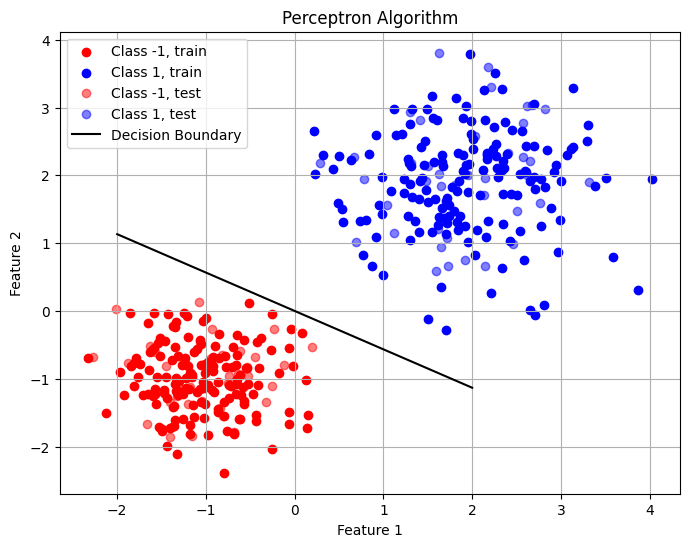

In [43]:
X_train, X_test, y_train, y_test = None, None, None, None

###### Your code here ######

# Split the data into training and testing sets
num_train = int(0.8 * X.shape[0])
perm = np.random.permutation(X.shape[0])
X_train = X[perm[:num_train]]
y_train = y[perm[:num_train]]
X_test = X[perm[num_train:]]
y_test = y[perm[num_train:]]
# Train the perceptron algorithm
w, saved_for_vizualization = train(X_train, y_train)
w_plot = np.array([w[1], w[2], w[0]])
w = w_plot
# Test the perceptron algorithm and print the numnber of missclassified points
metric = test(X_test, y_test, w)
print(f'Number of missclassified points on the test set: {metric}')
###########################

plot_decision_boundary(X_train, y_train, X_test, y_test, w)

### 3.5 Train, Test, and Visualization Script non-liear data

Redo all the steps from section 3.4 but this time with the non linear data

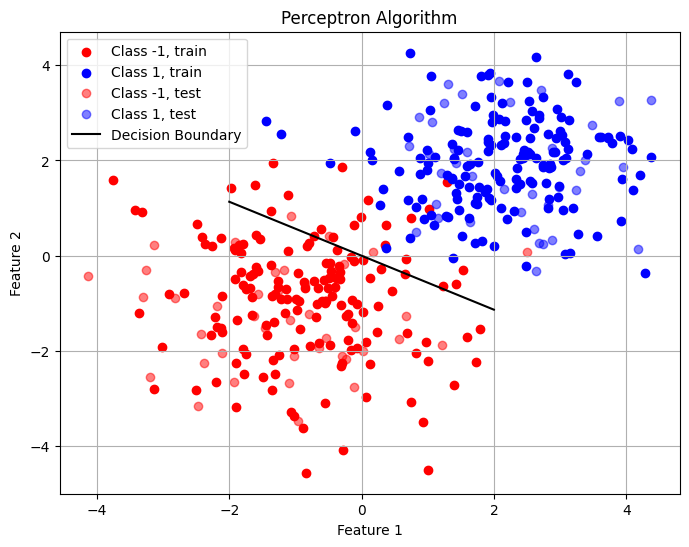

In [44]:
X_train, X_test, y_train, y_test = None, None, None, None

###### Your code here ######

# Split the data into training and testing sets
num_train = int(0.8 * X_n.shape[0])
perm = np.random.permutation(X_n.shape[0])
X_train = X_n[perm[:num_train]]
y_train = y_n[perm[:num_train]]
X_test = X_n[perm[num_train:]]
y_test = y_n[perm[num_train:]]
# Train the perceptron algorithm

# Test the perceptron algorithm and print the numnber of missclassified points

###########################

plot_decision_boundary(X_train, y_train, X_test, y_test, w)

### 3.6 Geometrical intuition

The script will generate plots for each iteration to illustrate how the algorithm works with the geometrical intuition discussed in the lab.

- The **orange line** represents the previous decision boundary.
- The **orange arrow** represents the weight vector $\mathbf{w} $, which is perpendicular to the decision boundary.
- The **green dot** marks the misclassified example, and the **green arrow** represents the vector $ y(t) \mathbf{x}(t) $.
- The **black arrow** shows the newly computed weight vector $ \mathbf{w} $, and the **black line** represents the corresponding updated decision boundary.

Note: change the `folder_path` variable to the desired one to save the images


In [45]:
import os
import matplotlib.pyplot as plt

def create_update_video(saved_for_vizualization, X_train, y_train, X_test, y_test, folder_path):
    # Check if the folder exists, if not, create it
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    for i in range(len(saved_for_vizualization)):
        w_t, w_t_1, x_t, y_t = saved_for_vizualization[i]

        fig, ax = plt.subplots(figsize=(8, 6))

        # Plot the data points
        ax.scatter(X_train[y_train == -1][:, 0], X_train[y_train == -1][:, 1], color='red', label='Class -1')
        ax.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='blue', label='Class 1')
        ax.scatter(X_test[y_test == -1][:, 0], X_test[y_test == -1][:, 1], color='red', alpha=0.5, label='Class -1, test')
        ax.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], color='blue', alpha=0.5, label='Class 1, test')

        ax.set_title('Perceptron Algorithm')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.legend()
        ax.grid(True)

        # Ensure the aspect ratio is equal to avoid distortion
        ax.set_aspect('equal')  # Set aspect ratio to 1:1

        # Set the limits of the plot to be between -5 and 5 on both axes
        ax.set_xlim([-5, 5])
        ax.set_ylim([-5, 5])

        # Initial decision boundary (w_t)
        x1 = np.linspace(-5, 5, 100)
        y1 = -(w_t[0] * x1 + w_t[2]) / w_t[1]
        ax.plot(x1, y1, color='orange', label='Initial decision Boundary')

        # Updated decision boundary (w_t_1)
        y2 = -(w_t_1[0] * x1 + w_t_1[2]) / w_t_1[1]
        ax.plot(x1, y2, color='black', label='Updated decision Boundary')

        # Highlight the point x_t being updated
        ax.scatter(x_t[0], x_t[1], color='green')

        ### Draw the normal vector (w_t) to the decision boundary in orange ###
        ax.arrow(0, 0, w_t[0], w_t[1], 
                 head_width=0.1, head_length=0.1, fc='orange', ec='orange', color='orange', 
                 label='Normal Vector')

        # Define the red vector based on the class label y_t
        if y_t == -1:
            red_vector = [-x_t[0], -x_t[1]]  # Opposite of x_t
            ax.arrow(0, 0, red_vector[0], red_vector[1],
                     head_width=0.1, head_length=0.1, fc='green', ec='green', color='green', 
                     label='Opposite x_t')
        else:
            red_vector = [x_t[0], x_t[1]]  # x_t vector
            ax.arrow(0, 0, red_vector[0], red_vector[1],
                     head_width=0.1, head_length=0.1, fc='green', ec='green', color='green', 
                     label='x_t')

        # Calculate the resulting vector (sum of the red vector and orange vector)
        result_vector_x = w_t[0] + red_vector[0]
        result_vector_y = w_t[1] + red_vector[1]

        # Draw the resulting vector as a black arrow
        ax.arrow(0, 0, result_vector_x, result_vector_y,
                 head_width=0.1, head_length=0.1, fc='black', ec='black', color='black', 
                 label='Resulting Vector (w_t + x_t)')

        # Save the figure to the specified folder
        plt.savefig(os.path.join(folder_path, f'plot_{i}.png'))

        # Close the plot to avoid displaying it
        plt.close(fig)

In [46]:
import os
from IPython.display import display, Image
from ipywidgets import Button, HBox, VBox, Output

folder_path = r"C:\Users\Cipleu\Documents\IULIA\SCOALA\master\Year_1_Semester_1\Machine Learning 1\Lab\Code\UTCN_DS_ML_1\Solved\perceptron_images"
create_update_video(saved_for_vizualization, X_train, y_train.reshape(-1), X_test, y_test.reshape(-1), folder_path)

# Load image file names from the folder
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]
image_files.sort()  # Sort the files alphabetically

# Display the first image
current_image_index = 0

# Create the output widget to display images
output = Output()

def show_image(index):
    """Display the image at the given index."""
    output.clear_output()
    with output:
        image_path = os.path.join(folder_path, image_files[index])
        display(Image(filename=image_path))

# Define button click event handlers
def on_next_button_clicked(b):
    global current_image_index
    if current_image_index < len(image_files) - 1:
        current_image_index += 1
        show_image(current_image_index)

def on_prev_button_clicked(b):
    global current_image_index
    if current_image_index > 0:
        current_image_index -= 1
        show_image(current_image_index)

# Create navigation buttons
next_button = Button(description="Next")
prev_button = Button(description="Previous")
next_button.on_click(on_next_button_clicked)
prev_button.on_click(on_prev_button_clicked)

# Display the initial image
show_image(current_image_index)

# Arrange the buttons and output in a layout
display(VBox([HBox([prev_button, next_button]), output]))